# Teoría de Decisiones: Modelo Schelling con Sugarscape.
    
- Eduardo Carrasco.

## Librerías Base:

In [1]:
import matplotlib.colors as mcolors
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
import random
import pandas as pd
from scipy.stats import entropy
from scipy.ndimage import label

## 1. Definición de funciones (1ra Línea de Investigación - Modelo Tolerancia):

In [2]:
def inicializar_grilla(n, p):
    """
    Inicializa una grilla bidimensional con celdas vacías, 
    azules y rojas según las probabilidades proporcionadas.
    Args:
        n (int): Tamaño de la grilla (n x n).
        p (list): Lista de probabilidades [p_vacía, p_azul, p_roja].

    Returns:
        np.ndarray: Grilla inicializada.
    """
    grilla = np.random.choice([0, 1, 2], size=(n, n), p=p)
    return grilla

def vecindad(posicion, grilla):
    """
    Determina una vecindad de Moore
    posicion (x,y) : celda a la cual vamos a conocer sus vecinos
    grilla : grilla para conocer vecinos
    """
    n,n = grilla.shape
    x, y = posicion
    vecindad = { "N":  grilla[(x-1) % n , y ],      ## % n para que se mantenga dentro: genera un toroide
                 "E":  grilla[ x , (y+1) % n] , 
                 "S":  grilla[(x+1) % n , y ],
                 "O":  grilla[ x , (y-1) % n],
                 "NO": grilla[(x-1) % n , (y-1) % n],
                 "NE": grilla[(x-1) % n , (y+1) % n],
                 "SO": grilla[(x+1) % n , (y-1) % n],
                 "SE": grilla[(x+1) % n , (y+1) % n]}
    return vecindad

def felicidad(posicion, grilla, t):
    """
    Calculo de felicidad de una celda
    posicion(x,y) : posicion a al cual vamos a determinar la felicidad, 
    dado si la cantidad de celdas iguales es igual o mayor a t (tolerancia)
    grilla : grilla base
    t: Cantidad de vecinos que soporta una celula para estar feliz. 
    Si la cantidad de vecinos difetentes a ella es menor a t, la celula esta feliz
    """
    nb = vecindad(posicion, grilla)
    cantidad_diferentes = 0
    
    for i in nb:
        if grilla[posicion] != nb[i] and grilla[posicion] != 0 and  nb[i]!=0:  
            # Si el vecino es diferente al individuo central suma 1
            cantidad_diferentes += 1
    if cantidad_diferentes <= t:         
        # si la cantidad de celdas diferentes de la vecindad es menor al umbral el individuo es feliz
        return True
    elif grilla[posicion] == 0:          
        # asume celdas cero felices por lo que los ceros no se mueven
        return True
    else:
        return False
    
def encontrar_celdas_infelices(grilla, t):
    """
    Encuentra todas las celdas infelices en la grilla según la tolerancia t.

    Args:
        grilla (np.ndarray): Grilla bidimensional.
        t (int): Tolerancia.

    Returns:
        list: Lista de índices de celdas infelices.
    """
    celdas_infelices = []
    n = grilla.shape[0]
    for i in range(n):
        for j in range(n):
            posicion = (i,j)
            if grilla[posicion ] != 0 and felicidad(posicion, grilla, t) == False:
                celdas_infelices.append(posicion)  # Convertir a índice unidimensional
    return celdas_infelices

def movimiento(posicion, grilla):
    x , y = posicion 
    grilla_aux = grilla.copy()
    direccion = [ "N", "E" ,"S","O", "NO","NE", "SO", "SE"]
    nb =  vecindad(posicion, grilla_aux)
    np.random.shuffle(direccion)
    for i in direccion:
        if nb[i] == 0:
            if i == "N":  
                grilla_aux[(x-1) % n , y ] = grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i == "E":  
                grilla_aux[ x , (y+1) % n] = grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i == "S":  
                grilla_aux[(x+1) % n , y ] = grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i =="O":  
                grilla_aux[ x , (y-1) % n] = grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i =="NO": 
                grilla_aux[(x-1) % n , (y-1) % n]= grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i =="NE": 
                grilla_aux[(x-1) % n , (y+1) % n]= grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i =="SO": 
                grilla_aux[(x+1) % n , (y-1) % n]= grilla_aux[posicion]
                grilla_aux[posicion] =0
            else:
                grilla_aux[(x+1) % n , (y+1) % n]= grilla_aux[posicion]
                grilla_aux[posicion] =0
                
    return grilla_aux    
    

def crear_gif(automata, n, pasos, p):
    nombre_archivo = f"SAKODA_size{n}_pasos{pasos}_dist{p}.gif"

    # Crear un mapa de colores personalizado
    cmap = mcolors.ListedColormap(['white', 'blue', 'red'])

    imagenes = []
    for idx, matriz in enumerate(automata):
        imagen = plt.imshow(matriz, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
        titulo = f"Generación {idx} \nDistr (vacio,azul,rojo) {p}"
        plt.title(titulo)
        plt.axis('on')
        filename = "temp.png"
        plt.savefig(filename)
        plt.close()

        image = imageio.v2.imread(filename)
        os.remove(filename)
        imagenes.append(image)

    imageio.mimsave(nombre_archivo, imagenes, fps=10)
    
def modelo_sakoda_schelling(n, p, t, pasos):
    """
    Ejecuta el modelo de Sakoda/Schelling y devuelve una lista de grillas.

    Args:
        n (int): Tamaño de la grilla (n x n).
        p (list): Lista de probabilidades [p_vacía, p_azul, p_roja].
        t (int): Tolerancia.
        pasos (int): Número de pasos a ejecutar.

    Returns:
        list: Lista de grillas.
    """
    grilla = inicializar_grilla(n, p)
    grillas = [grilla.copy()]  # Agregar la grilla inicial a la lista de grillas
    
    for s in range(pasos):
        celdas_infelices = encontrar_celdas_infelices(grillas[-1], t)
        if len(celdas_infelices) == 0:
            break
        celda = random.choice(celdas_infelices)
        nueva_grilla = movimiento(celda, grillas[-1])
        grillas.append(nueva_grilla)  # Agregar la grilla actualizada a la lista de grillas
    
    return grillas

def calcular_infelices(automata, t):
    """
    Calcula la cantidad de celdas infelices en cada paso.

    Args:
        automata (list): Lista de grillas.
        t (int): Tolerancia.

    Returns:
        list: Lista de cantidades de celdas infelices.
    """
    infelices = []
    for grilla in automata:
        celdas_infelices = encontrar_celdas_infelices(grilla, t)
        infelices.append(len(celdas_infelices))
    return infelices

### 1.1. Definición de Parámetros y Simulación:

In [3]:
random.seed(123)  # semilla random
np.random.seed(123)  # semilla NumPy

# Parámetros de entrada
n = 30  # Tamaño de la grilla (n x n)
p = [0.2, 0.4, 0.4]  # Probabilidad de celdas vacías, azules y rojas respectivamente
t = 2  # Tolerancia
pasos =10000 # Número de pasos

# Ejecutar el modelo de Sakoda/Schelling
automata = modelo_sakoda_schelling(n, p, t, pasos)

# Calcular la cantidad de celdas infelices en cada paso
infelices = calcular_infelices(automata, t)

len(automata)

10001

### 1.2. Generación de Gráfico:

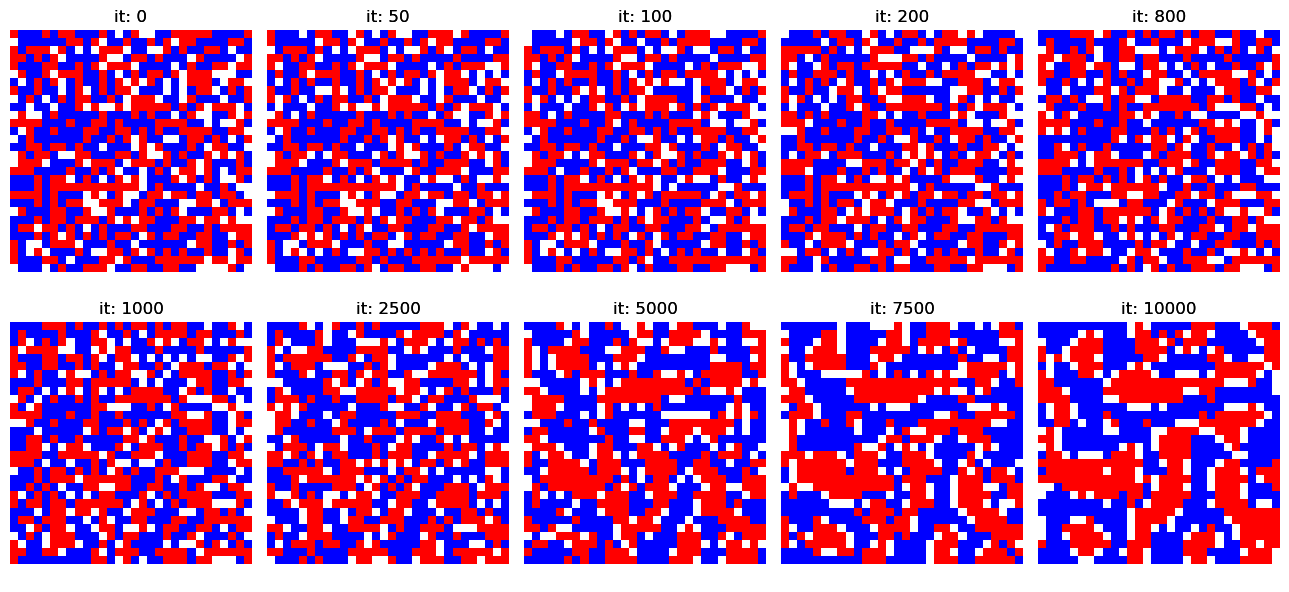

In [4]:
# Definir tamaño de la figura

iter_figuras = (0,50,100,200,800,1000,2500,5000,7500,10000)
fig, axes = plt.subplots(2,5, figsize = (13,6)) #    tres gráficos en una fila, ajustar según página d eword

for h in range(2):
    for g in range(5):
        axes[h,g].set_axis_off()
            
    for j in range(len(iter_figuras)):
        ax = fig.add_subplot(2, 5, j+1)       # i+1 porque los subplots se numeran desde 1
        cmap = mcolors.ListedColormap(['white', 'blue', 'red'])
        plt.imshow(automata[iter_figuras[j]], cmap=cmap, vmin=0, vmax=2, interpolation='nearest')
        ax.set_title("it: "+ str(iter_figuras[j]))
        ax.axis('off')
        # Ajustar la disposición de los subplots y mostrar la figura
    fig.tight_layout()

### 1.3. Métricas:

#### 1.3.1. Cantidad de Infelices en el tiempo:

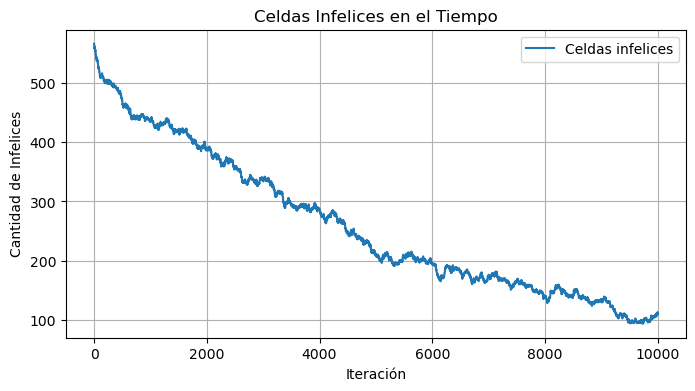

In [5]:
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(8, 4))

# Graficar la cantidad de celdas infelices
ax.plot(infelices, label='Celdas infelices')

# Configurar el gráfico
ax.set_xlabel('Iteración')
ax.set_ylabel('Cantidad de Infelices')
ax.set_title('Celdas Infelices en el Tiempo')
ax.grid()
ax.legend()

# Mostrar el gráfico
plt.show()

### 1.4. Creación Gif:

In [ ]:
### gif con saltos; ojo con la ram, 

def crear_gif(automata, n, pasos, p):
    nombre_archivo = f"SAKODA_size{n}_pasos{pasos}_dist{p}.gif"

    # Crear un mapa de colores personalizado
    cmap = mcolors.ListedColormap(['white', 'blue', 'red'])

    imagenes = []
    for idx, matriz in enumerate(automata):
        imagen = plt.imshow(matriz, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
        titulo = f"Generación {idx} \nDistr (vacio,azul,rojo) {p}"
        plt.title(titulo)
        plt.axis('off')
        filename = "temp1.png"
        plt.savefig(filename, dpi=50)  ## disminuyo dpi se vuelve más feo pero nmenos pesado
        plt.close()

        image = imageio.v2.imread(filename)
        os.remove(filename)
        imagenes.append(image)
        
    salto = 25        # Saltar cuadros (cambiar según la velocidad deseada)
    imagenes_reducidas = imagenes[::salto]  # Obtener una lista reducida de cuadros

    imageio.mimsave(nombre_archivo, imagenes_reducidas, fps=100) 
    
crear_gif(automata, n, pasos, p)

________

____

_____